# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

Признаки:

    DateCrawled — дата скачивания анкеты из базы
    VehicleType — тип автомобильного кузова
    RegistrationYear — год регистрации автомобиля
    Gearbox — тип коробки передач
    Power — мощность (л. с.)
    Model — модель автомобиля
    Kilometer — пробег (км)
    RegistrationMonth — месяц регистрации автомобиля
    FuelType — тип топлива
    Brand — марка автомобиля
    NotRepaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий автомобиля
    PostalCode — почтовый индекс владельца анкеты (пользователя)
    LastSeen — дата последней активности пользователя
    
Целевой признак:

    Price — цена (евро)

## Подготовка данных

In [1]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
conda install -c conda-forge lightgbm

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor, Pool, cv
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import lightgbm as lgb
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings('ignore')

In [4]:
data_auto = pd.read_csv('./autos.csv')
data_auto.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
#посмотрим дубли
data_auto.duplicated().sum()

4

In [6]:
#удалим дубли
data_auto = data_auto.drop_duplicates()
data_auto.duplicated().sum()

0

In [7]:
#пропуски
data_auto.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105795
RegistrationYear     0.000000
Gearbox              0.055968
Power                0.000000
Model                0.055607
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092828
Brand                0.000000
NotRepaired          0.200793
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

Есть пропуски в столбцах VehicleType, Gearbox , Model, FuelType, NotRepaired. Теперь посмотрим уникальные значения.

In [8]:
for column in data_auto.columns:
    print('------------------------------------------------')
    print('Уникальны значения столбца {} и их количества'. format(column))
    print('------------------------------------------------')
    print(data_auto[column].unique())
    print()
    print(data_auto[column].value_counts())

------------------------------------------------
Уникальны значения столбца DateCrawled и их количества
------------------------------------------------
['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']

2016-03-24 14:49:47    7
2016-03-19 21:49:56    6
2016-03-26 22:57:31    6
2016-03-20 16:50:22    5
2016-03-16 13:47:44    5
                      ..
2016-03-06 15:48:47    1
2016-03-27 20:49:00    1
2016-03-08 14:38:16    1
2016-03-25 15:46:35    1
2016-03-09 19:42:50    1
Name: DateCrawled, Length: 271174, dtype: int64
------------------------------------------------
Уникальны значения столбца Price и их количества
------------------------------------------------
[  480 18300  9800 ... 12395 18429 10985]

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
13440        1
1414         1
8069         1
10370        1
384          1
Name: Price, Length: 3731, dt

petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64
------------------------------------------------
Уникальны значения столбца Brand и их количества
------------------------------------------------
['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda'
 'nissan' 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat'
 'mini' 'smart' 'hyundai' 'sonstige_autos' 'alfa_romeo' 'subaru' 'volvo'
 'mitsubishi' 'kia' 'suzuki' 'lancia' 'toyota' 'chevrolet' 'dacia'
 'daihatsu' 'trabant' 'saab' 'chrysler' 'jaguar' 'daewoo' 'porsche'
 'rover' 'land_rover' 'lada']

volkswagen        77012
opel              39931
bmw               36914
mercedes_benz     32044
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              524

Вывод:
    
    В столбце Price много авто (10772) за 0 евро. Наверно, автомобиль уже куплен. Удалим аномальные значения и посмотрим по квантилям какие у нас будут границы.
    В RegistrationYear у некоторых авто указан год, который ещё не наступил. Например: 8455 или 3200 и т.д. Построим гистограмму и выберем границы, основываясь на квантилях.
    В Power 40225 авто без лошадинных сил (0) и с самой большой 16311, 15000 и т.д. Построим гистограмму и выберем границы с основной выборкой.
    В RegistrationMonth 37352 авто, у которых регистрационный месяц равен 0. Этот столбец для обучения моделей не пригодится, так как эти данные не особо важны. Оставим без изменения.
    Все анкеты машин без фото. Столбец NumberOfPictures не важен.

Выберем столбцы(признаки), которые влияют на цену автомобиля:
 
    -VehicleType — тип автомобильного кузова
    -RegistrationYear — год регистрации автомобиля
    -Gearbox — тип коробки передач
    -Power — мощность (л. с.)
    -Model — модель автомобиля
    -Kilometer — пробег (км)
    -FuelType — тип топлива
    -Brand — марка автомобиля
    -NotRepaired — была машина в ремонте или нет

Создадим датафрейм с нужными стобцами

In [9]:
auto = data_auto[['VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'FuelType', 'Brand',
       'NotRepaired', 'Price']]

In [10]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       316875 non-null  object
 1   RegistrationYear  354365 non-null  int64 
 2   Gearbox           334532 non-null  object
 3   Power             354365 non-null  int64 
 4   Model             334660 non-null  object
 5   Kilometer         354365 non-null  int64 
 6   FuelType          321470 non-null  object
 7   Brand             354365 non-null  object
 8   NotRepaired       283211 non-null  object
 9   Price             354365 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


Заменим пропуски на самое популярное значение в каждом столбце:

In [11]:
auto.fillna({'Gearbox':'manual',
            'Model':'unknown',
            'FuelType':'petrol',
            'NotRepaired':'no'}, inplace=True)
auto.isna().mean()

VehicleType         0.105795
RegistrationYear    0.000000
Gearbox             0.000000
Power               0.000000
Model               0.000000
Kilometer           0.000000
FuelType            0.000000
Brand               0.000000
NotRepaired         0.000000
Price               0.000000
dtype: float64

In [12]:
#выполним замену NaN в соотвествии с популярным типом кузова для каждого бренда.
vehicle_type_pivot_table = auto.pivot_table(index=['VehicleType'], 
                                                          columns=['Brand'],
                                                          values=['Price'],
                                                          aggfunc=['count'])

auto[auto['Brand'] == 'alfa_romeo']['VehicleType'].value_counts()
vehicle_type_pivot_table

count                                                      \
                 Price                                                       
Brand       alfa_romeo     audi      bmw chevrolet chrysler citroen  dacia   
VehicleType                                                                  
bus                NaN     10.0      7.0     159.0    436.0  1262.0   50.0   
convertible      180.0   1627.0   3266.0      17.0    238.0   114.0    NaN   
coupe            229.0   1499.0   3809.0      90.0     48.0   152.0    NaN   
other             15.0    110.0    242.0      46.0     10.0   121.0    6.0   
sedan            945.0  10965.0  17585.0     231.0    295.0   714.0  103.0   
small            239.0   1571.0    448.0     582.0     12.0  1590.0  223.0   
suv                1.0    180.0    818.0     384.0     23.0    36.0  215.0   
wagon            457.0  11081.0   7929.0     110.0    244.0   629.0  252.0   

                                     ...                          \
                                     ...                           
Brand       daewoo daihatsu    fiat  ...    seat   skoda   smart   
VehicleType                          ...                           
bus           27.0     36.0   833.0  ...   614.0   231.0     1.0   
convertible    1.0     17.0   520.0  ...     NaN     4.0  1132.0   
coupe          8.0      NaN   177.0  ...    87.0    10.0   341.0   
other          5.0     12.0   184.0  ...    74.0    26.0     9.0   
sedan        107.0     47.0   904.0  ...  1781.0   911.0    29.0   
small        268.0    527.0  5308.0  ...  3119.0  1124.0  3267.0   
suv            1.0     49.0    24.0  ...     4.0   173.0     NaN   
wagon         47.0     17.0   455.0  ...   399.0  2709.0     9.0   

                                                                             
                                                                             
Brand       sonstige_autos subaru suzuki  toyota trabant volkswagen   volvo  
VehicleType                                                                  
bus                  202.0   17.0   28.0   447.0     NaN     9536.0     NaN  
convertible          330.0    1.0   36.0    65.0    37.0     2963.0    75.0  
coupe                230.0    8.0    8.0   232.0     4.0     1784.0    69.0  
other                256.0    6.0   14.0    21.0     7.0      760.0     5.0  
sedan                486.0  168.0  183.0   895.0   230.0    19738.0   643.0  
small                261.0  119.0  984.0  1588.0    58.0    18531.0     7.0  
suv                  429.0   62.0  749.0   445.0     1.0     1331.0   221.0  
wagon                139.0  300.0   89.0   572.0    79.0    12659.0  1989.0  

[8 rows x 40 columns]

In [13]:
vehicle_type_pivot_table = vehicle_type_pivot_table['count']['Price']
vehicle_type_pivot_table

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
VehicleType,,,,,,,,,,,,,,,,,,,,,
bus,NaN,10.0,7.0,159.0,436.0,1262.0,50.0,27.0,36.0,833.0,...,614.0,231.0,1.0,202.0,17.0,28.0,447.0,NaN,9536.0,NaN
convertible,180.0,1627.0,3266.0,17.0,238.0,114.0,NaN,1.0,17.0,520.0,...,NaN,4.0,1132.0,330.0,1.0,36.0,65.0,37.0,2963.0,75.0
coupe,229.0,1499.0,3809.0,90.0,48.0,152.0,NaN,8.0,NaN,177.0,...,87.0,10.0,341.0,230.0,8.0,8.0,232.0,4.0,1784.0,69.0
other,15.0,110.0,242.0,46.0,10.0,121.0,6.0,5.0,12.0,184.0,...,74.0,26.0,9.0,256.0,6.0,14.0,21.0,7.0,760.0,5.0
sedan,945.0,10965.0,17585.0,231.0,295.0,714.0,103.0,107.0,47.0,904.0,...,1781.0,911.0,29.0,486.0,168.0,183.0,895.0,230.0,19738.0,643.0
small,239.0,1571.0,448.0,582.0,12.0,1590.0,223.0,268.0,527.0,5308.0,...,3119.0,1124.0,3267.0,261.0,119.0,984.0,1588.0,58.0,18531.0,7.0
suv,1.0,180.0,818.0,384.0,23.0,36.0,215.0,1.0,49.0,24.0,...,4.0,173.0,NaN,429.0,62.0,749.0,445.0,1.0,1331.0,221.0
wagon,457.0,11081.0,7929.0,110.0,244.0,629.0,252.0,47.0,17.0,455.0,...,399.0,2709.0,9.0,139.0,300.0,89.0,572.0,79.0,12659.0,1989.0


In [14]:
auto.fillna({'VehicleType':0},inplace=True)

#функция заменяет пропуски популярным типом кузова для каждого бренда
def fill(row, row_number, vehicle_type_pivot_table):
    brand = row[7]
    fill_value = row[row_number]
    if row[row_number] == 0:
        fill_value = vehicle_type_pivot_table[brand].idxmax()
    return fill_value

auto['VehicleType'] = auto.apply(fill, args=[0, vehicle_type_pivot_table], axis=1)
auto['VehicleType'].value_counts()

sedan          109309
small           95880
wagon           68223
bus             28908
convertible     20283
coupe           16161
suv             12313
other            3288
Name: VehicleType, dtype: int64

In [15]:
auto.describe()

,RegistrationYear,Power,Kilometer,Price
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,2004.234481,110.093816,128211.363989,4416.679830
std,90.228466,189.851330,37905.083858,4514.176349
min,1000.000000,0.000000,5000.000000,0.000000
25%,1999.000000,69.000000,125000.000000,1050.000000
50%,2003.000000,105.000000,150000.000000,2700.000000
75%,2008.000000,143.000000,150000.000000,6400.000000
max,9999.000000,20000.000000,150000.000000,20000.000000


Посмотрим цены на графике, чтобы выбрать основную выборку

count    343593.000000
mean       4555.147363
std        4515.076200
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

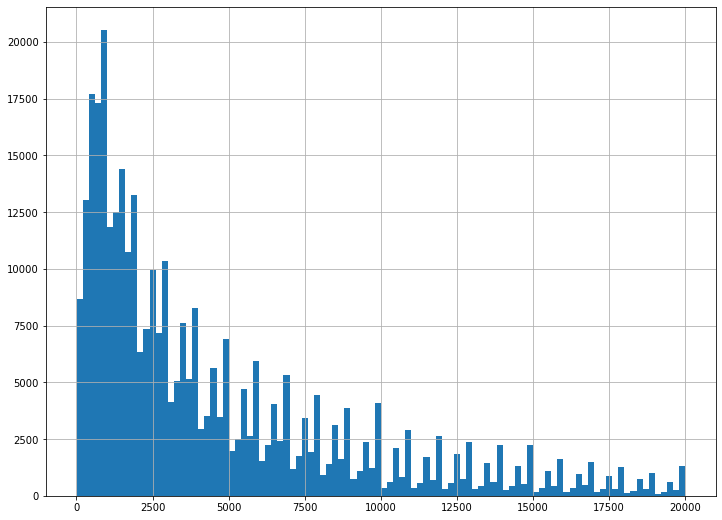

In [16]:
#10772 записи без цены. Удалим их и проверим распределение цены на гистограмме
auto = auto.query('Price > 0')
auto['Price'].hist(bins=100, figsize=(12,9))
auto['Price'].describe()

In [17]:
#выделим квантили 5% и 90%.
auto['Price'].quantile([.05, 0.9])

0.05      350.0
0.90    11500.0
Name: Price, dtype: float64

Стоимость 350 евро примерно равно 30800 рублей. Выбор 90% квантиля обоснован большими выбросами после 11500 евро.

In [18]:
auto = auto.query('350 <= Price <= 11500')
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294005 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       294005 non-null  object
 1   RegistrationYear  294005 non-null  int64 
 2   Gearbox           294005 non-null  object
 3   Power             294005 non-null  int64 
 4   Model             294005 non-null  object
 5   Kilometer         294005 non-null  int64 
 6   FuelType          294005 non-null  object
 7   Brand             294005 non-null  object
 8   NotRepaired       294005 non-null  object
 9   Price             294005 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 24.7+ MB


Посмотрим года регистрации

In [19]:
auto['RegistrationYear'].describe()

count    294005.000000
mean       2003.470944
std          67.062374
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

<AxesSubplot:>

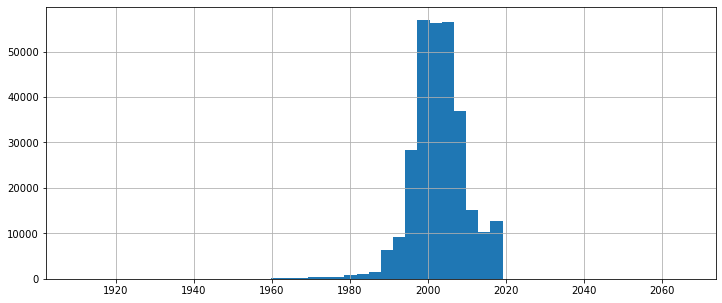

In [20]:
auto = auto.query('1900 < RegistrationYear < 2100')
auto['RegistrationYear'].hist(bins=50, figsize=(12,5))

<AxesSubplot:>

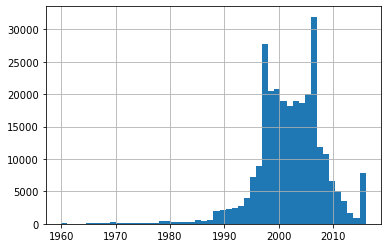

In [21]:
auto = auto.query('1959 < RegistrationYear <= 2016')
auto['RegistrationYear'].hist(bins=50)

Выберем актуальный период с 1959 по 2016

Осталось заняться некорректнымми значениями в столбце Power:

count    281030.000000
mean        107.635733
std         185.013711
min           0.000000
25%          70.000000
50%         102.000000
75%         140.000000
max       20000.000000
Name: Power, dtype: float64

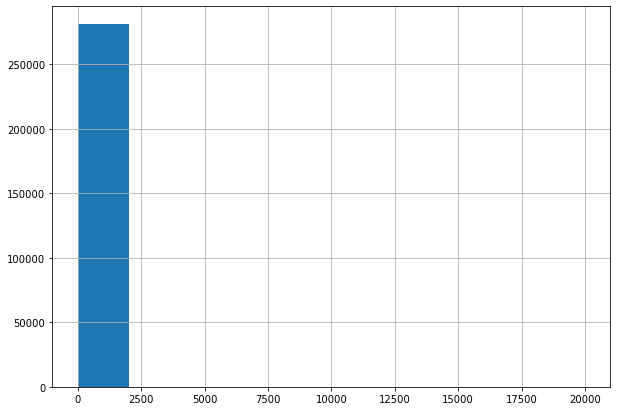

In [22]:
auto['Power'].hist(bins=10, figsize=(10,7))
auto['Power'].describe()

Раброс очень сильный, cделаем срез меньше 2500.

<AxesSubplot:>

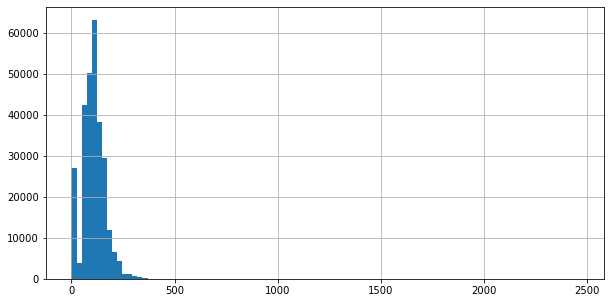

In [23]:
auto = auto.query('Power < 2500')
auto['Power'].hist(bins=100, figsize=[10,5])

<AxesSubplot:>

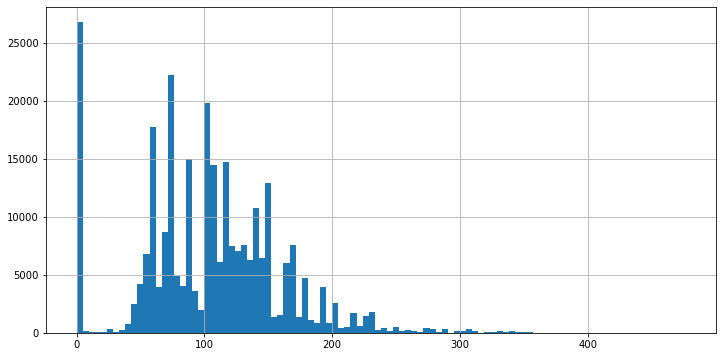

In [24]:
#снова срез меньше 500
auto = auto.query('Power < 500')
auto['Power'].hist(bins=100, figsize=[12,6])

На графике видно, что 0 - аномальные значения. Получается мощность авто больше 0 и меньше 350.

<AxesSubplot:>

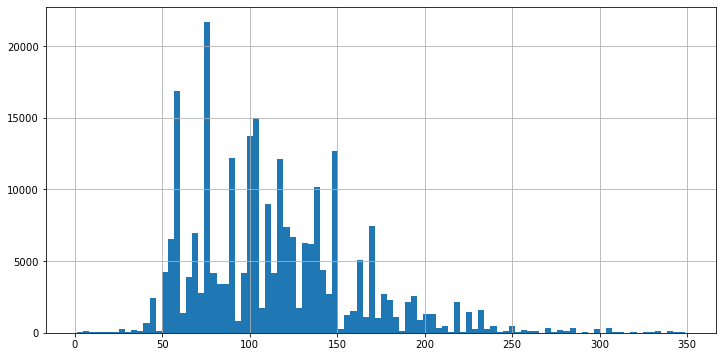

In [25]:
auto = auto.query('0 < Power < 350')
auto['Power'].hist(bins=100, figsize=[12,6])

Убрали аномальные значения, на графике показана основная выборка

In [26]:
#посмотрим размер данных
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253746 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       253746 non-null  object
 1   RegistrationYear  253746 non-null  int64 
 2   Gearbox           253746 non-null  object
 3   Power             253746 non-null  int64 
 4   Model             253746 non-null  object
 5   Kilometer         253746 non-null  int64 
 6   FuelType          253746 non-null  object
 7   Brand             253746 non-null  object
 8   NotRepaired       253746 non-null  object
 9   Price             253746 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 21.3+ MB


In [27]:
#уменьшим размер
auto['RegistrationYear'] = pd.to_numeric(auto['RegistrationYear'], downcast='integer')
auto['Power'] = pd.to_numeric(auto['Power'], downcast='integer')
auto['Kilometer'] = pd.to_numeric(auto['Kilometer'], downcast='integer')
auto['Price'] = pd.to_numeric(auto['Price'], downcast='integer')
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253746 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       253746 non-null  object
 1   RegistrationYear  253746 non-null  int16 
 2   Gearbox           253746 non-null  object
 3   Power             253746 non-null  int16 
 4   Model             253746 non-null  object
 5   Kilometer         253746 non-null  int32 
 6   FuelType          253746 non-null  object
 7   Brand             253746 non-null  object
 8   NotRepaired       253746 non-null  object
 9   Price             253746 non-null  int16 
dtypes: int16(3), int32(1), object(6)
memory usage: 16.0+ MB


Вывод:

 - тип данных соответствует;
 - нашли пропуски в столбцах: VehicleType, Gearbox, Model, FuelType, NotRepaired. Заменили на самое популярное значение каждого столбца;
 - было 4 дубликата, удалили их;
 - отобрали столбцы, важные для построения модели;
 - убрали выбросы и аномальные значения в стобцах: Price, RegistrationYear, Power;
 - уменьшили размер данных на 5.8 MB.

## Обучение моделей

Рассмотрим модели:
 - CatBoostRegressor;
 - RandomForestRegressor;
 - Ridge;
 - LightGBM;

Вначале закодируем данные Ordinal Encoding(порядковое кодирование) и выберем признаки.

In [28]:
#неизмененные принаки
original_features = auto.drop('Price', axis=1)

#создали копию датасета и поменяли тип данных с object на category для модели LGBM.
auto_light = auto.copy()
auto_light = auto_light.astype({"VehicleType":'category',
                                  "Gearbox":'category',
                                  "Model":'category',
                                  "FuelType":'category',
                                  "Brand":'category',
                                  "NotRepaired":'category'})
#закодировали
encoder = OrdinalEncoder()
auto_ordinal = pd.DataFrame(encoder.fit_transform(original_features),
                            columns=original_features.columns)

In [29]:
train_features, test_features, train_target, test_target = train_test_split(auto.drop('Price', axis=1),
                                                                           auto['Price'],
                                                                           test_size = 0.25,
                                                                           random_state = 12345)

train_features, valid_features, train_target, valid_target = train_test_split(train_features,
                                                                           train_target,
                                                                           test_size = 0.25,
                                                                           random_state = 12345)

train_features_light, test_features_light, train_target_light, test_target_light = train_test_split(
    auto_light.drop('Price', axis=1), auto_light['Price'], test_size = 0.25, random_state = 12345)

train_features_oe, test_features_oe, train_target_oe, test_target_oe = train_test_split(auto_ordinal,
                                                                                           auto['Price'],
                                                                                           test_size = 0.25,
                                                                                           random_state = 12345)

### CatBoostRegressor

In [30]:
%%time

model_cat = CatBoostRegressor(cat_features=["VehicleType","Gearbox",
                                            "Model","FuelType","Brand","NotRepaired"])
model_cat.fit(train_features, train_target, eval_set=(valid_features, valid_target), plot=True)
cv_params = model_cat.get_params() 
cv_params.update({'loss_function': 'MSE', 
                  'learning_rate':[0.1, 0.5, 0.8], 
                  'random_state':[12345]})
cv_data = cv(Pool(train_features, train_target),cv_params)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.117677
0:	learn: 2715.8737387	test: 2709.0411307	best: 2709.0411307 (0)	total: 113ms	remaining: 1m 52s
1:	learn: 2538.5763356	test: 2534.2488893	best: 2534.2488893 (1)	total: 156ms	remaining: 1m 17s
2:	learn: 2387.2698671	test: 2384.5315410	best: 2384.5315410 (2)	total: 198ms	remaining: 1m 5s
3:	learn: 2256.0221912	test: 2255.4270793	best: 2255.4270793 (3)	total: 246ms	remaining: 1m 1s
4:	learn: 2145.3269592	test: 2146.4551556	best: 2146.4551556 (4)	total: 280ms	remaining: 55.6s
5:	learn: 2047.1595098	test: 2049.6090243	best: 2049.6090243 (5)	total: 314ms	remaining: 52s
6:	learn: 1965.1322999	test: 1969.1335998	best: 1969.1335998 (6)	total: 351ms	remaining: 49.8s
7:	learn: 1890.4882725	test: 1895.7763799	best: 1895.7763799 (7)	total: 387ms	remaining: 48s
8:	learn: 1828.9177696	test: 1834.6077977	best: 1834.6077977 (8)	total: 422ms	remaining: 46.5s
9:	learn: 1769.6158777	test: 1776.3899250	best: 1776.3899250 (9)	total: 457ms	remaining: 45.2s
10:	learn: 1714.196332

91:	learn: 1243.4230037	test: 1266.1290963	best: 1266.1290963 (91)	total: 3.03s	remaining: 29.9s
92:	learn: 1242.6459661	test: 1265.3469547	best: 1265.3469547 (92)	total: 3.07s	remaining: 29.9s
93:	learn: 1242.0595688	test: 1264.7353972	best: 1264.7353972 (93)	total: 3.1s	remaining: 29.9s
94:	learn: 1241.5591690	test: 1264.3654703	best: 1264.3654703 (94)	total: 3.13s	remaining: 29.8s
95:	learn: 1240.8283769	test: 1263.7716008	best: 1263.7716008 (95)	total: 3.15s	remaining: 29.7s
96:	learn: 1240.1450020	test: 1263.2449185	best: 1263.2449185 (96)	total: 3.18s	remaining: 29.6s
97:	learn: 1239.5647447	test: 1262.7410953	best: 1262.7410953 (97)	total: 3.21s	remaining: 29.6s
98:	learn: 1239.0919621	test: 1262.2038860	best: 1262.2038860 (98)	total: 3.25s	remaining: 29.5s
99:	learn: 1238.3773910	test: 1261.4418726	best: 1261.4418726 (99)	total: 3.27s	remaining: 29.5s
100:	learn: 1237.5097583	test: 1260.6030909	best: 1260.6030909 (100)	total: 3.31s	remaining: 29.5s
101:	learn: 1236.7712788	test

175:	learn: 1199.4296885	test: 1226.3123495	best: 1226.3123495 (175)	total: 5.79s	remaining: 27.1s
176:	learn: 1198.9524055	test: 1225.9156843	best: 1225.9156843 (176)	total: 5.82s	remaining: 27.1s
177:	learn: 1198.6546205	test: 1225.6405723	best: 1225.6405723 (177)	total: 5.85s	remaining: 27s
178:	learn: 1198.1911657	test: 1225.2040874	best: 1225.2040874 (178)	total: 5.88s	remaining: 27s
179:	learn: 1197.8216073	test: 1224.9808750	best: 1224.9808750 (179)	total: 5.91s	remaining: 26.9s
180:	learn: 1197.4720690	test: 1224.7269579	best: 1224.7269579 (180)	total: 5.95s	remaining: 26.9s
181:	learn: 1197.0979286	test: 1224.3810484	best: 1224.3810484 (181)	total: 5.99s	remaining: 26.9s
182:	learn: 1196.6411707	test: 1224.0400517	best: 1224.0400517 (182)	total: 6.03s	remaining: 26.9s
183:	learn: 1196.3675147	test: 1223.7442760	best: 1223.7442760 (183)	total: 6.06s	remaining: 26.9s
184:	learn: 1195.9314769	test: 1223.3286415	best: 1223.3286415 (184)	total: 6.1s	remaining: 26.9s
185:	learn: 119

258:	learn: 1176.3997074	test: 1209.1502193	best: 1209.1502193 (258)	total: 8.82s	remaining: 25.3s
259:	learn: 1176.1222136	test: 1209.0055843	best: 1209.0055843 (259)	total: 8.85s	remaining: 25.2s
260:	learn: 1175.9348296	test: 1208.8665207	best: 1208.8665207 (260)	total: 8.88s	remaining: 25.2s
261:	learn: 1175.7028259	test: 1208.6807234	best: 1208.6807234 (261)	total: 8.91s	remaining: 25.1s
262:	learn: 1175.4126160	test: 1208.4460486	best: 1208.4460486 (262)	total: 8.95s	remaining: 25.1s
263:	learn: 1175.2430578	test: 1208.3573786	best: 1208.3573786 (263)	total: 8.98s	remaining: 25s
264:	learn: 1174.8977924	test: 1208.1310778	best: 1208.1310778 (264)	total: 9.03s	remaining: 25s
265:	learn: 1174.6196369	test: 1207.9625680	best: 1207.9625680 (265)	total: 9.06s	remaining: 25s
266:	learn: 1174.2368628	test: 1207.5935066	best: 1207.5935066 (266)	total: 9.11s	remaining: 25s
267:	learn: 1174.1456761	test: 1207.5417178	best: 1207.5417178 (267)	total: 9.14s	remaining: 25s
268:	learn: 1173.933

345:	learn: 1160.4986894	test: 1198.1679616	best: 1198.1679616 (345)	total: 11.9s	remaining: 22.6s
346:	learn: 1160.3954428	test: 1198.1341488	best: 1198.1341488 (346)	total: 12s	remaining: 22.5s
347:	learn: 1160.2879242	test: 1198.0557360	best: 1198.0557360 (347)	total: 12s	remaining: 22.5s
348:	learn: 1160.0780378	test: 1197.8497036	best: 1197.8497036 (348)	total: 12s	remaining: 22.5s
349:	learn: 1159.8857671	test: 1197.6958220	best: 1197.6958220 (349)	total: 12.1s	remaining: 22.4s
350:	learn: 1159.8818330	test: 1197.7085721	best: 1197.6958220 (349)	total: 12.1s	remaining: 22.4s
351:	learn: 1159.6800175	test: 1197.6427158	best: 1197.6427158 (351)	total: 12.1s	remaining: 22.4s
352:	learn: 1159.5831967	test: 1197.6076184	best: 1197.6076184 (352)	total: 12.2s	remaining: 22.3s
353:	learn: 1159.3255546	test: 1197.3720600	best: 1197.3720600 (353)	total: 12.2s	remaining: 22.3s
354:	learn: 1159.1163990	test: 1197.3301315	best: 1197.3301315 (354)	total: 12.2s	remaining: 22.2s
355:	learn: 1159

431:	learn: 1148.8709584	test: 1190.7828249	best: 1190.7828249 (431)	total: 15.2s	remaining: 19.9s
432:	learn: 1148.6217948	test: 1190.5589993	best: 1190.5589993 (432)	total: 15.2s	remaining: 19.9s
433:	learn: 1148.5266959	test: 1190.4566687	best: 1190.4566687 (433)	total: 15.2s	remaining: 19.9s
434:	learn: 1148.3363275	test: 1190.3842168	best: 1190.3842168 (434)	total: 15.3s	remaining: 19.8s
435:	learn: 1148.2300546	test: 1190.3164254	best: 1190.3164254 (435)	total: 15.3s	remaining: 19.8s
436:	learn: 1148.0924870	test: 1190.2659456	best: 1190.2659456 (436)	total: 15.3s	remaining: 19.8s
437:	learn: 1147.9546505	test: 1190.1621073	best: 1190.1621073 (437)	total: 15.4s	remaining: 19.7s
438:	learn: 1147.8587955	test: 1190.0806841	best: 1190.0806841 (438)	total: 15.4s	remaining: 19.7s
439:	learn: 1147.7681293	test: 1190.0028113	best: 1190.0028113 (439)	total: 15.5s	remaining: 19.7s
440:	learn: 1147.7358582	test: 1189.9876712	best: 1189.9876712 (440)	total: 15.5s	remaining: 19.6s
441:	learn

518:	learn: 1139.1340778	test: 1185.2173346	best: 1185.2173346 (518)	total: 18.4s	remaining: 17.1s
519:	learn: 1139.0554270	test: 1185.1588072	best: 1185.1588072 (519)	total: 18.5s	remaining: 17.1s
520:	learn: 1138.8868762	test: 1185.1408444	best: 1185.1408444 (520)	total: 18.5s	remaining: 17s
521:	learn: 1138.7638656	test: 1185.0153970	best: 1185.0153970 (521)	total: 18.6s	remaining: 17s
522:	learn: 1138.7275004	test: 1185.0007552	best: 1185.0007552 (522)	total: 18.6s	remaining: 17s
523:	learn: 1138.6043408	test: 1184.9559099	best: 1184.9559099 (523)	total: 18.6s	remaining: 16.9s
524:	learn: 1138.4398677	test: 1184.9030661	best: 1184.9030661 (524)	total: 18.7s	remaining: 16.9s
525:	learn: 1138.4167547	test: 1184.8917021	best: 1184.8917021 (525)	total: 18.7s	remaining: 16.9s
526:	learn: 1138.3737551	test: 1184.8720358	best: 1184.8720358 (526)	total: 18.8s	remaining: 16.8s
527:	learn: 1138.3238699	test: 1184.8228554	best: 1184.8228554 (527)	total: 18.8s	remaining: 16.8s
528:	learn: 1138

606:	learn: 1130.7257265	test: 1181.3571993	best: 1181.3571993 (606)	total: 22.3s	remaining: 14.5s
607:	learn: 1130.6777493	test: 1181.3216530	best: 1181.3216530 (607)	total: 22.4s	remaining: 14.4s
608:	learn: 1130.6365152	test: 1181.3310090	best: 1181.3216530 (607)	total: 22.4s	remaining: 14.4s
609:	learn: 1130.4099851	test: 1181.1830138	best: 1181.1830138 (609)	total: 22.4s	remaining: 14.3s
610:	learn: 1130.3605594	test: 1181.1702738	best: 1181.1702738 (610)	total: 22.5s	remaining: 14.3s
611:	learn: 1130.2756544	test: 1181.1433359	best: 1181.1433359 (611)	total: 22.5s	remaining: 14.3s
612:	learn: 1130.1440141	test: 1181.0978341	best: 1181.0978341 (612)	total: 22.6s	remaining: 14.3s
613:	learn: 1129.9931155	test: 1181.0272190	best: 1181.0272190 (613)	total: 22.6s	remaining: 14.2s
614:	learn: 1129.8032937	test: 1180.9291189	best: 1180.9291189 (614)	total: 22.7s	remaining: 14.2s
615:	learn: 1129.7155377	test: 1180.8863024	best: 1180.8863024 (615)	total: 22.7s	remaining: 14.2s
616:	learn

694:	learn: 1123.7461081	test: 1177.8696332	best: 1177.8674758 (693)	total: 26.3s	remaining: 11.5s
695:	learn: 1123.6446337	test: 1177.7832971	best: 1177.7832971 (695)	total: 26.3s	remaining: 11.5s
696:	learn: 1123.5820690	test: 1177.7429658	best: 1177.7429658 (696)	total: 26.4s	remaining: 11.5s
697:	learn: 1123.5435348	test: 1177.6883323	best: 1177.6883323 (697)	total: 26.4s	remaining: 11.4s
698:	learn: 1123.5411922	test: 1177.6847198	best: 1177.6847198 (698)	total: 26.4s	remaining: 11.4s
699:	learn: 1123.5139958	test: 1177.6566223	best: 1177.6566223 (699)	total: 26.5s	remaining: 11.3s
700:	learn: 1123.4237369	test: 1177.6267249	best: 1177.6267249 (700)	total: 26.6s	remaining: 11.3s
701:	learn: 1123.3504730	test: 1177.5953484	best: 1177.5953484 (701)	total: 26.6s	remaining: 11.3s
702:	learn: 1123.2627873	test: 1177.5426855	best: 1177.5426855 (702)	total: 26.7s	remaining: 11.3s
703:	learn: 1123.2440783	test: 1177.5483171	best: 1177.5426855 (702)	total: 26.7s	remaining: 11.2s
704:	learn

782:	learn: 1117.2238582	test: 1174.9599724	best: 1174.9599724 (782)	total: 30.5s	remaining: 8.46s
783:	learn: 1117.2168480	test: 1174.9614511	best: 1174.9599724 (782)	total: 30.6s	remaining: 8.43s
784:	learn: 1117.1321221	test: 1174.9272512	best: 1174.9272512 (784)	total: 30.6s	remaining: 8.39s
785:	learn: 1117.0179998	test: 1174.8818197	best: 1174.8818197 (785)	total: 30.7s	remaining: 8.35s
786:	learn: 1116.9986010	test: 1174.8658838	best: 1174.8658838 (786)	total: 30.7s	remaining: 8.31s
787:	learn: 1116.8687019	test: 1174.7982377	best: 1174.7982377 (787)	total: 30.8s	remaining: 8.28s
788:	learn: 1116.8021277	test: 1174.7383443	best: 1174.7383443 (788)	total: 30.8s	remaining: 8.24s
789:	learn: 1116.6695769	test: 1174.6531839	best: 1174.6531839 (789)	total: 30.9s	remaining: 8.2s
790:	learn: 1116.6257707	test: 1174.6303132	best: 1174.6303132 (790)	total: 30.9s	remaining: 8.16s
791:	learn: 1116.5755641	test: 1174.6069576	best: 1174.6069576 (791)	total: 30.9s	remaining: 8.13s
792:	learn:

867:	learn: 1111.3275269	test: 1172.2916386	best: 1172.2904032 (866)	total: 34.8s	remaining: 5.29s
868:	learn: 1111.1807507	test: 1172.1927729	best: 1172.1927729 (868)	total: 34.8s	remaining: 5.25s
869:	learn: 1111.1389526	test: 1172.1573084	best: 1172.1573084 (869)	total: 34.9s	remaining: 5.21s
870:	learn: 1111.1354645	test: 1172.1564140	best: 1172.1564140 (870)	total: 35s	remaining: 5.18s
871:	learn: 1111.0994103	test: 1172.1440835	best: 1172.1440835 (871)	total: 35s	remaining: 5.14s
872:	learn: 1111.0264776	test: 1172.1069406	best: 1172.1069406 (872)	total: 35.1s	remaining: 5.1s
873:	learn: 1110.9902852	test: 1172.1046985	best: 1172.1046985 (873)	total: 35.1s	remaining: 5.06s
874:	learn: 1110.9424020	test: 1172.1314636	best: 1172.1046985 (873)	total: 35.1s	remaining: 5.02s
875:	learn: 1110.8941955	test: 1172.0607734	best: 1172.0607734 (875)	total: 35.2s	remaining: 4.98s
876:	learn: 1110.8007443	test: 1172.0014059	best: 1172.0014059 (876)	total: 35.3s	remaining: 4.94s
877:	learn: 111

955:	learn: 1106.2503647	test: 1170.1205196	best: 1170.1205196 (955)	total: 38.9s	remaining: 1.79s
956:	learn: 1106.2230420	test: 1170.1184164	best: 1170.1184164 (956)	total: 39s	remaining: 1.75s
957:	learn: 1106.1792676	test: 1170.0680781	best: 1170.0680781 (957)	total: 39s	remaining: 1.71s
958:	learn: 1106.1253207	test: 1170.0382647	best: 1170.0382647 (958)	total: 39.1s	remaining: 1.67s
959:	learn: 1106.0588474	test: 1170.0449975	best: 1170.0382647 (958)	total: 39.1s	remaining: 1.63s
960:	learn: 1106.0079984	test: 1169.9912505	best: 1169.9912505 (960)	total: 39.2s	remaining: 1.59s
961:	learn: 1105.9800323	test: 1169.9902579	best: 1169.9902579 (961)	total: 39.2s	remaining: 1.55s
962:	learn: 1105.9502577	test: 1169.9763184	best: 1169.9763184 (962)	total: 39.3s	remaining: 1.51s
963:	learn: 1105.9424139	test: 1169.9776649	best: 1169.9763184 (962)	total: 39.3s	remaining: 1.47s
964:	learn: 1105.8652886	test: 1169.9347653	best: 1169.9347653 (964)	total: 39.3s	remaining: 1.43s
965:	learn: 11

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=0]="wagon": Cannot convert 'b'wagon'' to float

In [31]:
%%time

ypred = model_cat.predict(test_features)
catboost_rmse = mean_squared_error(test_target, ypred) ** 0.5
print('RMSE модели CatBoost:', catboost_rmse)

RMSE модели CatBoost: 1151.5662719955822
CPU times: user 914 ms, sys: 34.5 ms, total: 949 ms
Wall time: 252 ms


### RandomForestRegressor

In [32]:
%%time

rfr = RandomForestRegressor(criterion = "mse", random_state=12345 , n_estimators = 100)
rfr.fit(train_features_oe,train_target_oe)

CPU times: user 39.7 s, sys: 318 ms, total: 40 s
Wall time: 40 s


RandomForestRegressor(random_state=12345)

In [33]:
%%time

ypred = rfr.predict(test_features_oe)
rfr_rmse = mean_squared_error(test_target, ypred) ** 0.5
print('RMSE модели Ridge:', rfr_rmse)

RMSE модели Ridge: 1152.5925644528998
CPU times: user 1.8 s, sys: 11.1 ms, total: 1.81 s
Wall time: 1.81 s


### Ridge

In [34]:
%%time

rgd = Ridge()
parametrs = [{'solver':['auto', 'svd', 'cholesky', 'lsqr','sparse_cg']}]

grid = GridSearchCV(rgd, parametrs, scoring='neg_mean_squared_error')
grid.fit(train_features_oe,train_target_oe)
print('Лучший параметр:', grid.best_params_)

Лучший параметр: {'solver': 'svd'}
CPU times: user 3 s, sys: 105 ms, total: 3.1 s
Wall time: 810 ms


In [35]:
%%time

ypred = grid.predict(test_features_oe)
ridge_rmse = mean_squared_error(test_target, ypred) ** 0.5
print('RMSE модели Ridge:', ridge_rmse)

RMSE модели Ridge: 2044.248688455252
CPU times: user 11.6 ms, sys: 1.45 ms, total: 13 ms
Wall time: 3.25 ms


### LightGBM

In [36]:
cat_features=['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired']
gbm_features = list(train_features.columns)

In [37]:
%%time

lgb_train = lgb.Dataset(train_features_light, label = train_target_light, feature_name = gbm_features, 
                        categorical_feature = cat_features)
param = {'learning_rate':0.25, 'n_estimators':100, 'objective':'root_mean_squared_error'}
num_round = 1000
lgb_model = lgb.train(param, lgb_train, num_round)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 578
[LightGBM] [Info] Number of data points in the train set: 190309, number of used features: 9
[LightGBM] [Info] Start training from score 3723.704659
CPU times: user 2.85 s, sys: 66 ms, total: 2.92 s
Wall time: 415 ms


In [38]:
%%time

ypred = lgb_model.predict(test_features_light)
gbm_rmse = mean_squared_error(test_target, ypred) ** 0.5
print('RMSE модели LightGBM:', gbm_rmse)

RMSE модели LightGBM: 1143.963116507718
CPU times: user 747 ms, sys: 38.4 ms, total: 785 ms
Wall time: 107 ms


Вывод:

    Обучили 4 модели с лучшими параметрами, так же посчитали RMSE.

## Анализ моделей

Нас интересуют 3 условия, при выборе модели:

- качество предсказания;
- скорость предсказания;
- время обучения.

Распишем все 4 модели по условиям: 

    - по качеству предсказания

        1. LightGBM = 1143.96;
        2. CatBoost = 1151.56;
        3. RandomForest = 1152.59;
        4. Ridge = 2044.24.

    - по скорости предсказания 

        1. Ridge = 13мс;
        2. CatBoost = 617мс;
        3. LightGBM = 785мс;
        4. RandomForest = 1.81с.

    - по времени обучения

        1. LightGBM ~ 2.92с;
        2. Ridge ~ 3.1с;
        3. RandomForest ~ 40с;
        4. CatBoost ~ 40.8с.
      

По качеству предсказаний модель LightGBM = 1143.96 допускает меньше всех ошибок, так же время ее обучения состовляет 2.92с. Если сравнивать Ridge и LightGBM модели, то лучшая из них LightGBM, так как Ridge допускает почти в два раза ошибок (2044.24) больше. Это самый худший результат по качеству предсказаний, чем у остальных моделей.

Если сравнивать CatBoost с LightGBM, то разница в ошибках небольшая, но зато по времени обучения CatBoost (~ 40.8с) намного отстаёт. Скорость предсказания у этих двух моделей сильно отличается. Так же фаворитом выходит модель LightGBM.

И последняя модель RandomForest, по всем показателям она уступает модели LightGBM. 
    
Отсюда можно сделать вывод, что самая подходящая модель по качеству предсказания, по скорости предсказания и по времени обучения является модель LightGBM.